# Zillow Project  <a class="tocSkip">


# Goal: <a class="tocSkip">
* Uncover drivers that influence a home's value
* Use machine learning algorithms with drivers to accurately predict a future home's value
* Develop an understanding on how the drivers influence a home's value

# Drivers being targeted: <a class="tocSkip">
* **Square footage:** Is a home's value influenced by it's square feet?
* **Bedroom count:** Is a home's value influenced by the number of bedrooms it has?
* **Bathroom count:** Is a home's value influenced by the number of bathrooms it has?
* **FIPS:**  Is a home's value influenced by its FIPS code?

## Imports <a class="tocSkip">

In [1]:
import pandas as pd
import numpy as np
from pydataset import data
import os
import env
import acquire as a
import prepare as p
import wrangle as w
import evaluate as e
import visual as viz

#Stats imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind, chi2_contingency


#visual imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#sklearn split, impute, math stuff
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Scalers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")


# Acquire <a class="tocSkip">
- Data acquired form SQL Database
- It contained 56,079 rows and 7 columns
- Each row represents a home transaction
- Each column represents a feature of that home

In [2]:
# Acquire Zillow data
df = w.wrangle_zillow()

# Prepare  <a class="tocSkip">

- Data processed for investingating:
    - Dropped 32 rows of duplicated data. About 0.05% of data
    - Dropped 557 rows that had missing data. About 1.0% of data.
    - Dropped year built column. Not being targreted as a driver.
    - Dropped tax amount column. Correlation value is too high. Would negatively impact model performance.
    - Dropped outliers:
        - Homes over 99th percentile in square feet, tax value, bedrooms, and bathrooms
        - Dropped any homes that were listed with 0 bedrooms or 0 bathrooms.

In [3]:
# Drop the outliers
df = p.drop_outliers(df)

# Preparing data for exploration. Split data into three sets: train, validate, test.
train, val, test = p.split_data_continious(df)

# Data Dictionary <a class="tocSkip">

In [4]:
%%html
<style>
table {float:left}
</style>

| Feature | Definition |
| :-- | :-- |
| bedrooms | number of bedrooms |
| bathrooms | number of bathrooms |
| sq_ft | total square footage of home's living area<br>living area does not include basements, garages, or yards|
| tax_value | the house property value in USD | 
| fips | Federal Information Processing System<br>- fips 6037: Los Angeles County<br>- fips 6059: Orange County<br>- fips 6111: Ventura County |



# Glance into Zillow's Data<a class="tocSkip">

In [5]:
df.head()

,bedrooms,bathrooms,sq_ft,tax_value,fips
0,2.0,1.0,1412.0,222671.0,6037.0
1,3.0,2.0,1296.0,64968.0,6037.0
2,3.0,1.0,1044.0,126800.0,6037.0
3,3.0,2.0,1336.0,213833.0,6037.0
4,3.0,2.0,1510.0,338022.0,6037.0


# Explore<a class="tocSkip">
- Explore Data. Answer questions to uncover drivers.
- **Questions:**
    * **Q1.** Is a home's value influenced by it's square feet?
    * **Q2.** Is a home's value influenced by the number of bedrooms it has?
    * **Q3.** Is a home's value influenced by the number of bathrooms it has?
    * **Q4.**  Is a home's value influenced by its FIPS code?
- Utilize drivers in machine learning model

### Correlations Table<a class="tocSkip">

In [6]:
round(train.corr(),4)

,bedrooms,bathrooms,sq_ft,tax_value,fips
bedrooms,1.0000,0.6030,0.5972,0.2496,0.1535
bathrooms,0.6030,1.0000,0.8114,0.4855,0.1184
sq_ft,0.5972,0.8114,1.0000,0.5695,0.1309
tax_value,0.2496,0.4855,0.5695,1.0000,0.0609
fips,0.1535,0.1184,0.1309,0.0609,1.0000


<div class="alert alert-block alert-info">
Correlation:<br>
- Square Feet/ tax_value: 56.95% correlated<br>
- Bedrooms / tax_value: 24.96% correlated<br>
- Bathrooms / tax_value: 48.55% correlated<br>

## Q1. Is a home's value influenced by it's square feet?<a class="tocSkip">

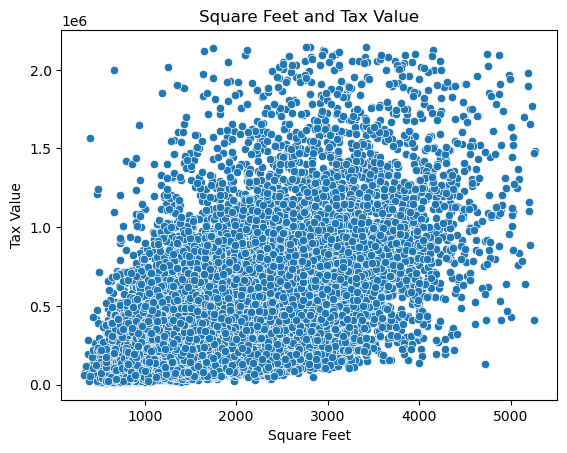

In [7]:
viz.scatter('sq_ft','tax_value',train)

<div class="alert alert-block alert-info">
Takeaways:<br>
    
- Highest Density: 1000-4000 square feet
    
- Around 100,000 - $1.5 million dollars

- As square feet increases, tax value also increases

### Statistic Test<a class="tocSkip">


**H0: There is no significant relation between a home's value and it's square footage.**

**Ha: There is a significant relation between a home's value and it's square footage.**

confidence interval: 95%

alpha = 0.05

**Pearson R Test** 

In [8]:
p.pearsonr(train,'sq_ft','tax_value')

Results
--------
Correlation: 0.5695
P-value: 0.0


<div class="alert alert-block alert-info">
Takeaways:<br>
    
- P-value is lower than alpha of 0.05. 

- With this result, we can say with confidence that there is a significant relation between square footage and tax value.
    
    
- **Square feet will be considered a driver of tax value.**

## Q2. Is a home's value influenced by the number of bedrooms it has?<a class="tocSkip">

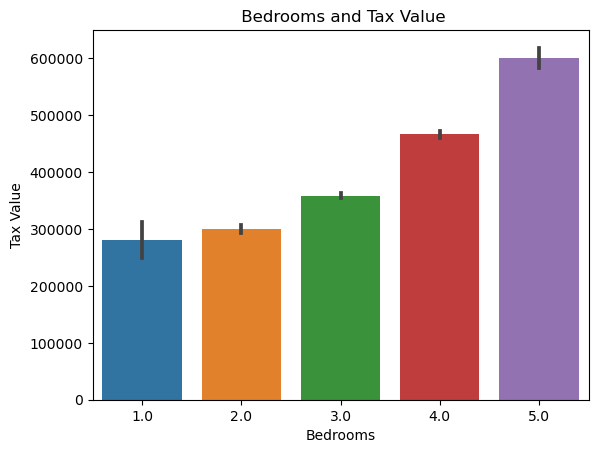

In [9]:
viz.barplot('bedrooms','tax_value', train)

<div class="alert alert-block alert-info">
Takeaways:<br>
    
As number of bedrooms increase, the tax value increases.<br>

### Statistics Test<a class="tocSkip">



**H0: There is no significant relation between a home's value and it's number of bedrooms.**

**Ha: There is a significant relation between a home's value and it's number of bedrooms.**

confidence interval: 95%

alpha = 0.05

**Independent T-test**

In [10]:
p.ttest(train)

Results
--------
Test statistic: -288.2163
P-value: 0.0


<div class="alert alert-block alert-info">
Takeaways:<br>
    
- P-value is lower than alpha of 0.05. 

- With this result, we can say with confidence that there is a significant relation between bedrooms and tax value.
  
    
- **Bedrooms will be considered a driver of tax value.**

## Q2. Is a home's value influenced by the number of bathrooms it has?<a class="tocSkip">

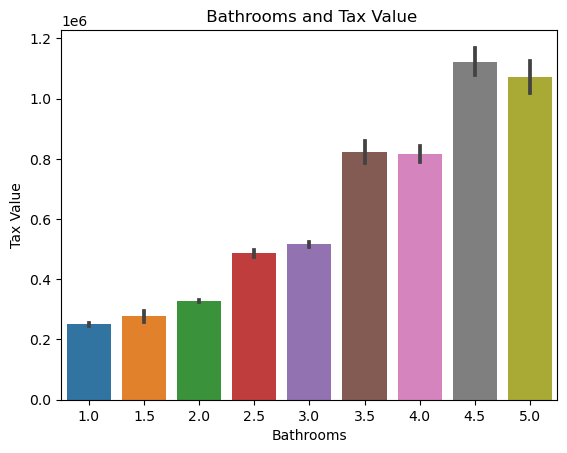

In [11]:
viz.barplot2(train)

<div class="alert alert-block alert-info">
Takeaways:<br>
    
As number of bathrooms increase, the average home's value increases.<br>
Interestingly, adding a half bath(powder room) drastically increases a home's value. 

The only exception is going fron 4.5 baths to 5.

**It is evident that number of bathrooms influences tax value. Bathrooms will be considered a driver of tax value.**

## Is a home's value influenced by its FIPS code?<a class="tocSkip">

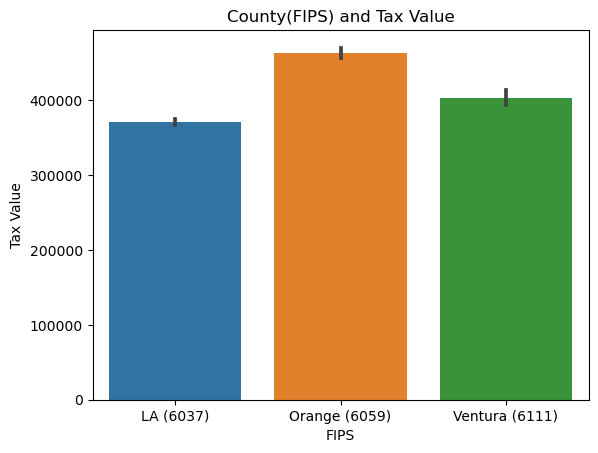

In [12]:
viz.barplot3(train)

<div class="alert alert-block alert-info">
Takeaways:<br>
    
- Depending on the county, the average home value increases or decreases.
- Orange County is the most expensive followed by LA County.

### Statistics Test<a class="tocSkip">

**H0: There is significant relation between a home's value and it's FIPS.**

**Ha: There is a significant relation between a home's value and it's FIPS.**

confidence interval: 95%

alpha = 0.05

**Independent T-test**

In [13]:
p.ttest1samp(train)

Results
--------
Test statistic: 17.61
P-value: 5.0095029459878605e-68


<div class="alert alert-block alert-info">
Takeaways:<br>
    
- P-value is lower than alpha of 0.05. 

- With this result, we can say with confidence that there is a significant relation between the FIPS code and tax value.
  
    
- **FIPS will be considered a driver of tax value.**

## Exploration Summary<a class="tocSkip">

<div class="alert alert-block alert-success">

- Square Feet: will be considered as a driver
- Bedrooms: will be considered as a driver
- Bathrooms: will be considered as a driver
- FIPS: will be considered as a driver


# Modeling<a class="tocSkip">

- Root Mean Squared Error(RMSE) will be the metric used to evaluate the models performance.
- Baseline will be set to the RMSE value of the average home price of 396,582.55.


**Score to Beat:**
- Baseline: 313,382.77

-**Four different models will be tested: Linear Regreassion, Lasso Lars, General Linear Model, Polynomial Regression**

-**Best performing model moves on to the test data set.**

In [14]:
# Scaling Data and created engineered columns for Modeling
scaled_train, scaled_val, scaled_test = p.scaled_dummies_base(train, val, test)

In [15]:
# Creating X and y trains
X_train, y_train, X_val, y_val, X_test, y_test = p.xy_trains(scaled_train, scaled_val, scaled_test)

## Linear Regression<a class="tocSkip">

In [16]:
e.linear(X_train, y_train, X_val, y_val, scaled_train, scaled_val)

RMSE Results
-------------
Baseline: 313382.77
Linear Regression Train Data: 253848.58
Linear Regression Validate Data: 246592.99
Difference: 7255.6


## Lasso Lars<a class="tocSkip">

In [17]:
e.lassolars(X_train, y_train, X_val, y_val, scaled_train, scaled_val)

RMSE Results
-------------
Baseline: 313382.77
Lasso Lars Train Data: 253846.23
Lasso Lars Validate Data: 246574.56
Difference: 7271.67


## Generalized Linear Model<a class="tocSkip">

In [18]:
e.glm(X_train, y_train, X_val, y_val, scaled_train, scaled_val)

RMSE Results
-------------
Baseline: 313382.77
Generlized Linear Model Train Data: 309772.76
Generalized Linear Model Validate Data: 302651.84
Difference: 7120.93


## Polynomial Regression<a class="tocSkip">

In [19]:
e.polyreg(X_train, y_train, X_val, y_val, scaled_train, scaled_val)

RMSE Results
-------------
Baseline: 313382.77
Polynomial Regression Train Data: 251383.34
Polynomial Regression Validate Data: 244714.41
Difference: 6668.93


## Comparing Models<a class="tocSkip">

- Linear Regression Difference: 7255.6
- Lasso Lars Difference: 7271.67
- Generalized Linear Model Difference: 7120.93
- Polynomial Regression Difference: 6668.93


<div class="alert alert-block alert-success">

- Linear Regression, Lasso Lars, and General Linear models performance were very similar.<br>
- Polynomial Regression performed slightly better the other three.
    
- <b>Polynomial will move forward with the test data set.
 


## Polynomial Regression with Test Dataset<a class="tocSkip">

In [20]:
e.polytest(X_train, y_train, X_val, y_val, X_test, y_test, scaled_train, scaled_val, scaled_test)

RMSE Results
-------------
Baseline: 313382.77
Polynomial Regression Validate Data: 244714.41
Polynomial Regression Model Test Data: 250611.83
Difference: -5897.42


<div class="alert alert-block alert-success">

<b> Polynomial Regression Performance: **62,770**  better than the baseline.
    

# Conclusions<a class="tocSkip">

# Exploration<a class="tocSkip">

**Explored 4 features of homes:**
- Square Feet
- Bedrooms
- Bathrooms
- FIPS

**All 4 features proved to have a significant relation with a home's tax value.** 

# Modeling<a class="tocSkip">

- Final Model: Polynomial Regression was able to perform better than the baseline by **62,770**.
    - Baseline: 313,382.77
    - Final Model: 250,611.83
    - Difference: 62,770.17

# Recommendations<a class="tocSkip">

- I would recommending filling in missing data to minimize the need to drop rows.

# Next Steps<a class="tocSkip">

- With more time given, I would explore how a home's lot size influences its value.
- I would also look into how a home's value is influence by the year it was built.